# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0                                          # initialize the score
# step = 1
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    #print(f"Step : {step} - Reward : {reward} - Done : {done}")
    #step += 1
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from collections import deque, namedtuple

### Hyperparameters
- BUFFER_SIZE : the capacity of the replay buffer - a store of samples $<s, a, r, s'>$
- BATCH_SIZE : the minibatch size that is sampled from the replay buffer and used to train the local network
- GAMMA : the discount factor (used to discount the future rewards)
- TAU : factor used for the soft updates of the weights in the target network
- LR : learning rate
- UPDATE_EVERY : periodicity in steps : how often the weights are updated

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

### Device

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

device : cpu


### Replay Memory
Buffer that stores samples $<s, a, r, s'>$

In [9]:
class Buffer:
    """Fixed-size buffer to store experience tuples"""
    def __init__(self, buffer_size, device):
        """Initialize a ReplayBuffer object
        
        Params
        ======
            buffer_size (int) : maximum length of buffer
            
        """
        self.device = device
        self.memory = deque(maxlen = buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory"""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self, n):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k= n)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Network Architecture
Simple NN  with 3 fully connected layers and relu activations
- Input : state observed from the environment
- Output : a vector of q-values where each q-value corresponds to an action 

In [10]:
class QNetwork(nn.Module):
    """Agent Q_Value function model"""
    def __init__(self, state_size, action_size, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Learning Agent
Agent that runs episodes of interactions with the environment. The agent samples periodically a batch of past interactions from its replay buffer in order to update the weights of its local network. In order to stabilize the learning process, the agent uses two networks (Double DQN): 
- a local network : its parameters $w$ are updated using gradient descent
- a target network : a mirror of the local network, its parameters $w^{-}$ are "copied" from the local network using soft update; the role of the target network is to provide stable targets (labels in a supervised learning context).

The weights $w$ of the local network are updated following gradient descent :
$$\Delta w = \alpha * [R + \gamma * max_{a} \hat{q}(s', a, w^{-}) - \hat{q}(s, a, w)] * \nabla \hat{q}(s, a, w)$$

The weights $w^{-}$ of the target network follow the updates of the $w$ more slowly (soft updates):
    $$w^{-} = \tau * w + (1 - \tau) * w^{-}$$
Without these more stable targets, we would encounter a harmful form of correlation whereby we shift the weights of the network based on constantly moving targets.


In [11]:
class Agent() :
    """
    Learning Agent with Replaying Buffer and double QNetwork
    Collects interactions with environment in replaying buffer
    Trains(learns) periodically by uniform sampling of interactions in replay buffer

    Params
    ======
        state_size (int): dimension of each state
        action_size (int): dimension of each acti
    """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # Q_networks
        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)
        # replay memory
        self.memory = Buffer(BUFFER_SIZE, device)
        # step counter    
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done) :
        # save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # learn every UPDATE_EVERY time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0 :
            # if enough samples are available in memory get random subset and learn
            if len(self.memory) > BATCH_SIZE :
                # experiences = self.memory.sample(BATCH_SIZE)
                self.learn()
        
    def act(self, state, eps=0.):
        """ Returns action for given state as per current policy
            Params
            ======
            state (array-like) : current state
            eps (float) : epsilon for epsilon greedy selection
            [Note : use default eps = 0. when exploiting trained network]
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps :
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self):
        """Update value parameters using given batch of experience tuples
        Params
        ======
        experiences (tuple[torch.variable]): tuple of (s, a , r, s', done) tuples
        gamma : discount factor
        """
        experiences = self.memory.sample(BATCH_SIZE)
        states, actions, rewards, next_states, dones = experiences
       
        # Get max predicted Q values (for next states) for target model
        qtargets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        qtargets = rewards + (GAMMA * qtargets_next * (1 - dones))
        # Get expected Q values from local model
        qexpected = self.qnetwork_local(states).gather(1, actions)
    
        # Compute loss
        loss = F.mse_loss(qexpected, qtargets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
       
    def soft_update(self, local_model, target_model, tau):
        """ Soft update model parameters
        θ_target = τ*θ_local + (1 - τ)*θ_target
        
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    def run_episode(self, env, brain_name, eps, max_t=1000, train=True):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        td_errors = []

        for t in range(max_t):
            action = self.act(state, eps) 

            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]


            # Get max predicted Q value (for next state) for target model
            next_state1 = torch.from_numpy(next_state).unsqueeze(0).float()
            qtarget_next = self.qnetwork_target(next_state1).detach().max(1)[0].unsqueeze(1).item()
            # Compute Q target for current state
            qtarget = reward + (GAMMA * qtarget_next * (1 - done))
            # Get expected Q value from local model
            state = torch.from_numpy(state).unsqueeze(0).float()
            qexpected = np.asarray(self.qnetwork_local(state).detach())[0][action]

            td_errors.append(np.abs(qexpected - qtarget))

            if train :
                self.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done :
                break
        
        return score, np.mean(td_errors)

    def train(self, env, brain_name, n_episodes = 2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
        tds_window = deque(maxlen=100)
        scores_window = deque(maxlen=100)
        scores = []
        eps = eps_start

        for i_episode in range(1, n_episodes + 1):
            score, avg_error = self.run_episode(env, brain_name, eps)
            scores.append(score)
            scores_window.append(score)
            tds_window.append(avg_error)

            eps = max(eps_end, eps_decay * eps) # decrease epsilon

            print('\rEpisode {}\tAverage Score: {:.2f}\tAverage Error: {:.2f}'.format(i_episode, np.mean(scores_window), np.mean(tds_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if np.mean(scores_window)>=15.0:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tAverage Error: {:.2f}'.format(i_episode, np.mean(scores_window),np.mean(tds_window)))
                torch.save(self.qnetwork_local.state_dict(), 'checkpoint.pth')
                break
        
        return scores

### Train the Agent

In [12]:
# train agent
agent = Agent(state_size, action_size)
scores = agent.train(env, brain_name)

Episode 100	Average Score: 0.61	Average Error: 0.03
Episode 200	Average Score: 4.52	Average Error: 0.07
Episode 300	Average Score: 7.46	Average Error: 0.08
Episode 400	Average Score: 10.71	Average Error: 0.09
Episode 500	Average Score: 13.04	Average Error: 0.09
Episode 600	Average Score: 14.58	Average Error: 0.09
Episode 649	Average Score: 15.04	Average Error: 0.09
Environment solved in 649 episodes!	Average Score: 15.04	Average Error: 0.09


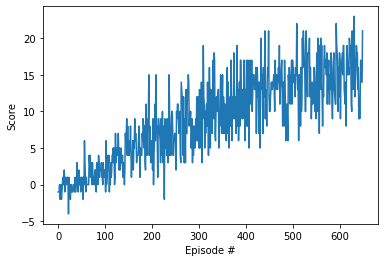

In [23]:
# plot the scores
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('scores.jpg')
plt.show()


### Test the Agent

In [14]:
# test the agent
score, td_avg = agent.run_episode(env, brain_name, 0., train=False)
print("Score: {:.0f}\t Average Temporal Difference: {:.2f}".format(score, td_avg))

Score: 20	 Average Temporal Difference: 0.09


In [18]:
# test the agent with the pretrained model
import torch
trained_model = QNetwork(state_size, action_size).to(device)
trained_model.load_state_dict(torch.load('checkpoint.pth'))
trained_model.eval()
agent = Agent(state_size, action_size)
agent.qnetwork_local = trained_model
score, _ = agent.run_episode(env, brain_name, 0., train=False)
print("Score: {:.0f}".format(score))

Score: 12


### Close the environment

In [19]:
env.close()